In [1]:
import os
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.io import read_raw_egi

In [4]:
# ścieżka do plików, podaj poprawną:
base_dir = r'C:\Users\swps\Dropbox\DANE\CAT N170\EEG\RAW'

# tworzymy listę plików i szukamy pliku z 'CAT107' w nazwie
files = os.listdir(base_dir)
relevant_files = [f for f in files if 'CAT107' in f]
print(relevant_files)
if len(relevant_files) == 0:
    raise FileNotFoundError('Niestety nie masz poprawnego pliku na dysku :(')

['CAT107 20131027 1648002.raw']


In [7]:
# wybieramy nazwę pliku i zapisujemy w zmiennej `file`
file = relevant_files[0]
print(file)

CAT107 20131027 1648002.raw


In [5]:
# tryb interaktywny
%matplotlib

Using matplotlib backend: Qt4Agg


In [8]:
file_path = op.join(base_dir, file)
print(file_path)

# wczytujemy plik
raw = read_raw_egi(file_path, preload=True, verbose=False)
print('\n', raw)

# filtrowanie
raw.filter(0.5, None)

# wyświetlamy dane
raw.plot(duration=5., n_channels=32, order='original');

C:\Users\swps\Dropbox\DANE\CAT N170\EEG\RAW\CAT107 20131027 1648002.raw

 <RawEGI  |  CAT107 20131027 1648002.raw, n_channels x n_times : 73 x 184036 (736.1 sec), ~102.6 MB, data loaded>


In [9]:
raw.plot(duration=15., n_channels=64, order='original');

In [11]:
# wczytujmey montaż i wyświetlamy
from mypy.chans import correct_egi_channel_names
from mypy.events import get_events_from_din, remove_din_channels
from mypy.viz import set_3d_axes_equal

montage = mne.channels.read_montage('GSN-HydroCel-65_1.0')
correct_egi_channel_names(raw)
raw.set_montage(montage)

fig = raw.plot_sensors(kind='3d', ch_groups='position')
set_3d_axes_equal(fig.axes[0]) # to jest tylko po to aby wyrównać osie

407 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 407 events and 251 original time points ...
0 bad epochs dropped
Adding average EEG reference projection.
1 projection items deactivated


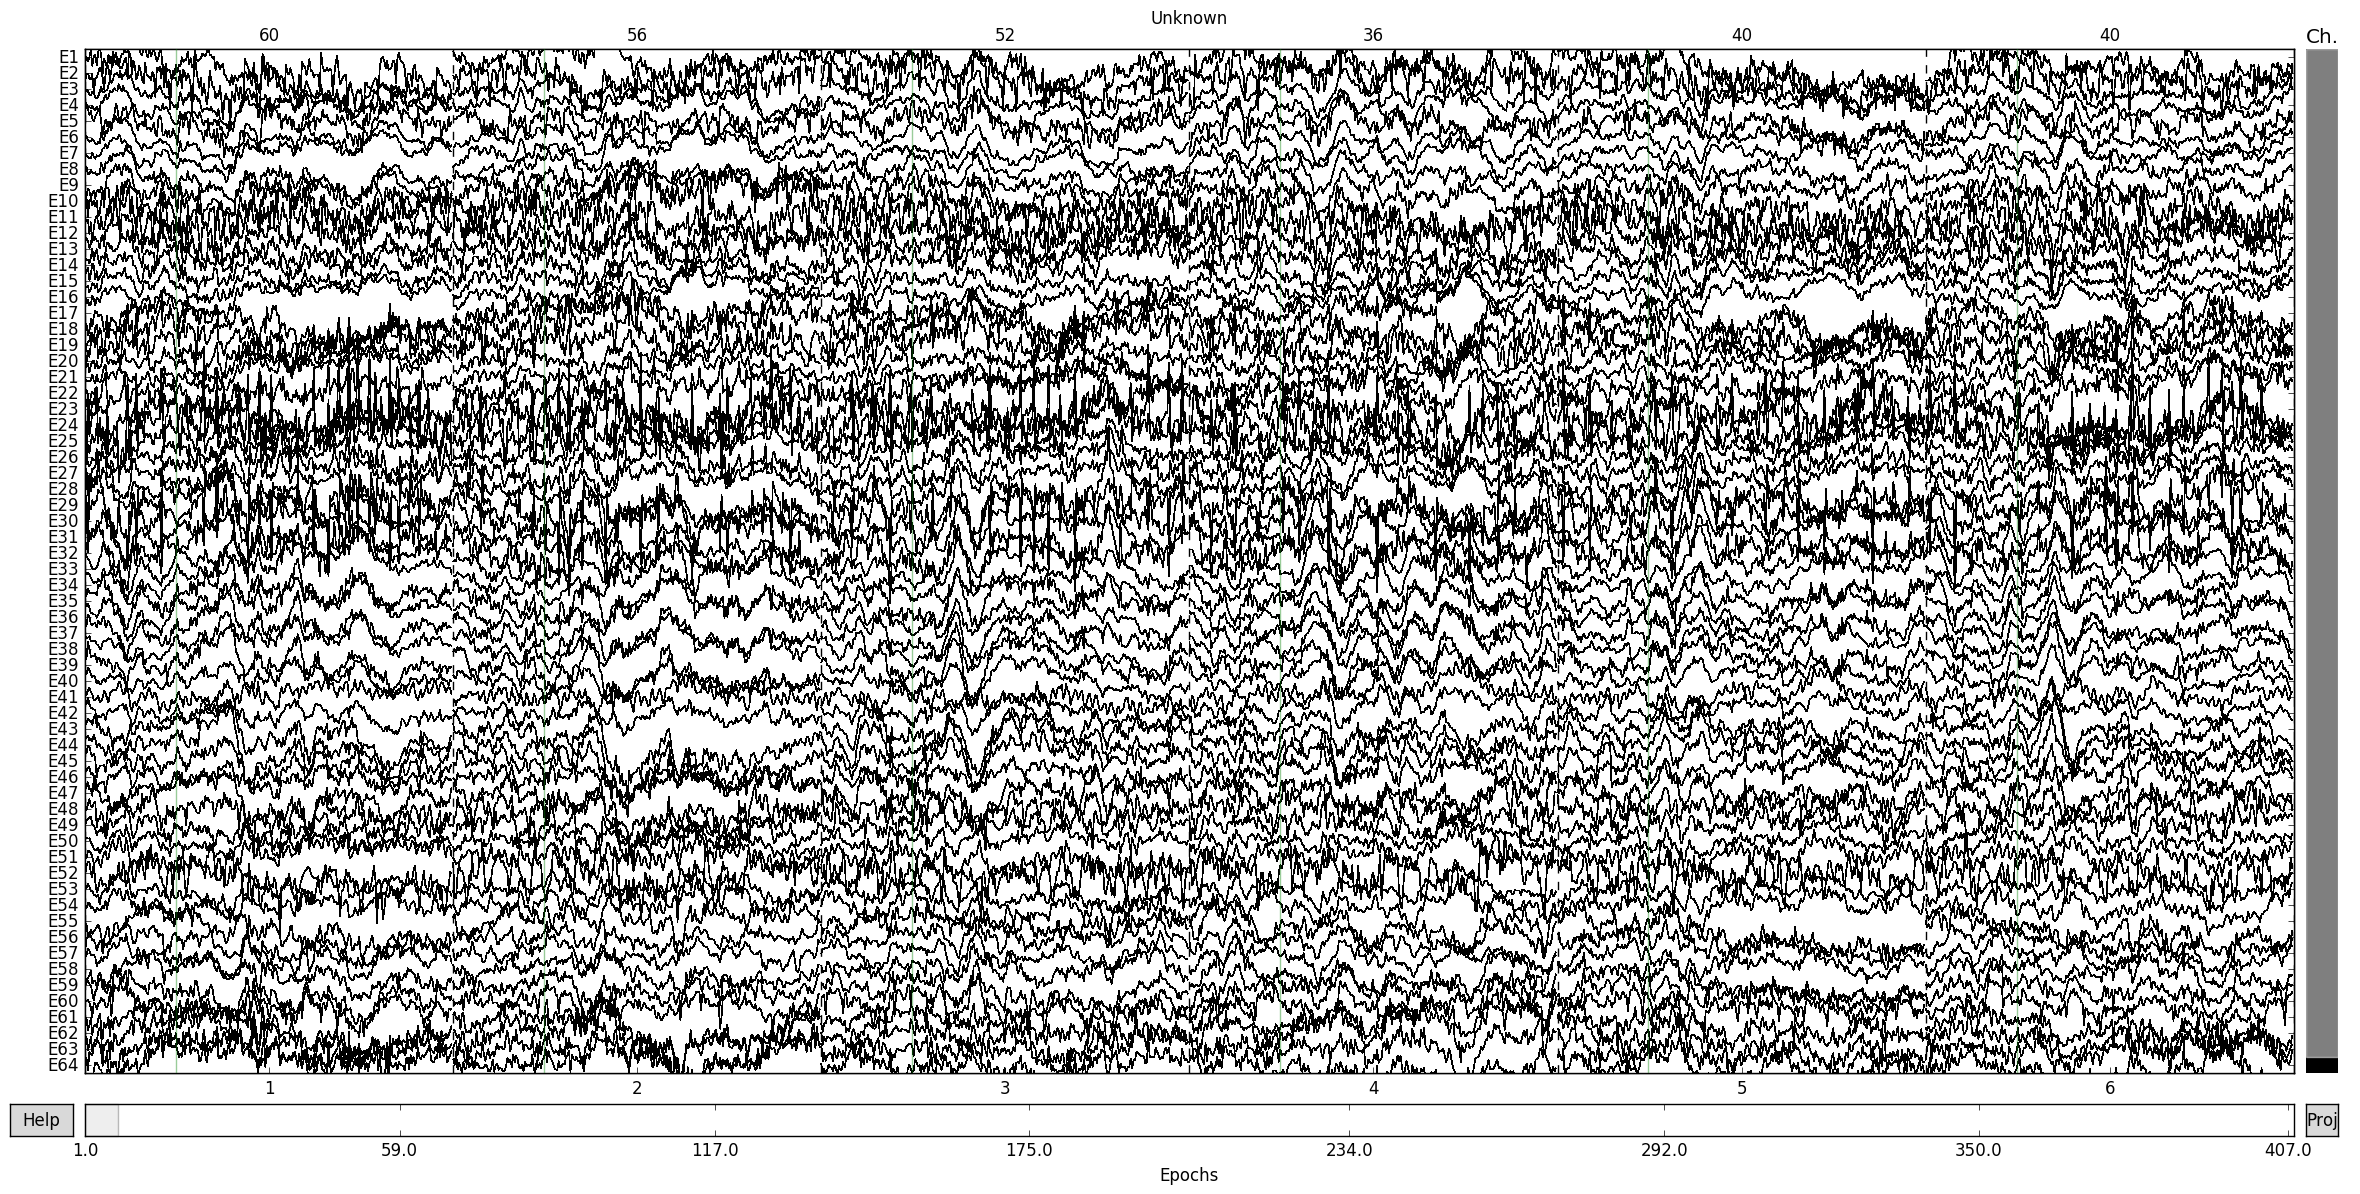

Dropped 27 epochs
Channels marked as bad: ['E23']


In [12]:
# bierzemy wydarzenia z kanałów DIN
events = get_events_from_din(raw)

# wywalamy kanały typu DIN - mamy już wydarzenia
remove_din_channels(raw)

# teraz tworzymy słownik tylko z wydarzeniami, względem których będziemy epokować:
event_id = { "car/0": 36, "car/90": 40, "car/180": 44,
            "face/0": 52, "face/90": 56, "face/180": 60}

# epokujemy:
epochs = mne.Epochs(raw, events, tmax=0.75, tmin=-0.25,
                    event_id=event_id, preload=True)

epochs.set_eeg_reference()
epochs.plot(n_epochs=6, n_channels=64)

In [13]:
# ustawiamy referencję do średniej
epochs.set_eeg_reference()
epochs.apply_proj()

An average reference projection was already added. The data has been left untouched.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


<ipython-input-13-fa9a69b8f71b>:2: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference()


SSP projectors applied...


<Epochs  |  n_events : 380 (all good), tmin : -0.248 (s), tmax : 0.752 (s), baseline : (None, 0), ~47.4 MB, data loaded,
 'car/0': 63, 'car/180': 64, 'car/90': 63, 'face/0': 60, 'face/180': 67, 'face/90': 63>

In [15]:
from mne.preprocessing.ica import ICA
ica = ICA(method='extended-infomax', n_components=0.95, max_iter=385)
ica.fit(epochs)

Fitting ICA to data using 64 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Selection by explained variance: 21 components
computing Extended Infomax ICA


<ICA  |  epochs decomposition, fit (extended-infomax): 95380 samples, 21 components, channels used: "eeg">

In [20]:
ica.plot_components(picks=list(range(0, 20)), inst=epochs);

In [23]:
# most comp
ica.plot_properties(picks=[0, 1, 2, 3], inst=epochs, image_args=dict(sigma=2.5))

In [22]:
# muscle artif
ica.plot_properties(picks=13, inst=epochs, dB=False, image_args=dict(sigma=0.5))

In [24]:
ica.plot_sources(epochs);

In [25]:
ica.exclude

[13, 8, 6, 9, 4, 0]

In [26]:
erp = epochs.copy().apply_baseline().average()
ica.plot_overlay(erp);

Applying baseline correction (mode: mean)
Transforming to ICA space (21 components)
Zeroing out 6 ICA components


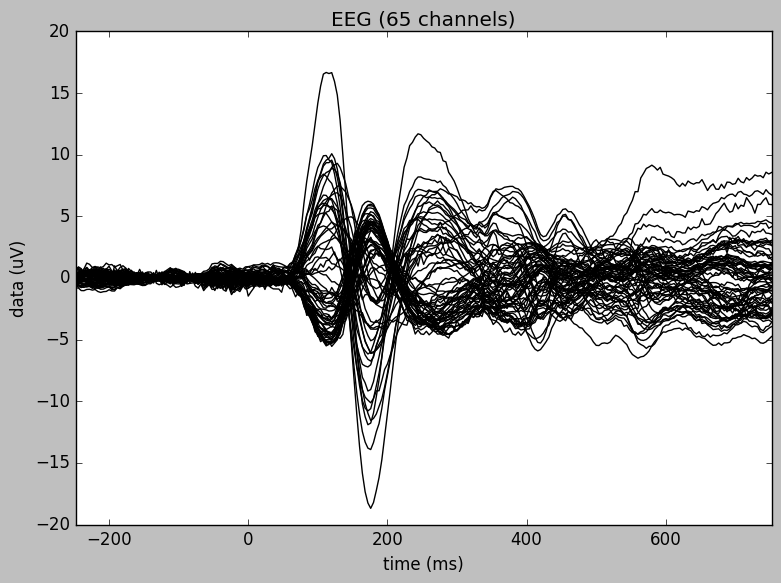

In [83]:
erp.plot()

In [27]:
epochs_clean = ica.apply(epochs.copy())

Transforming to ICA space (21 components)
Zeroing out 6 ICA components


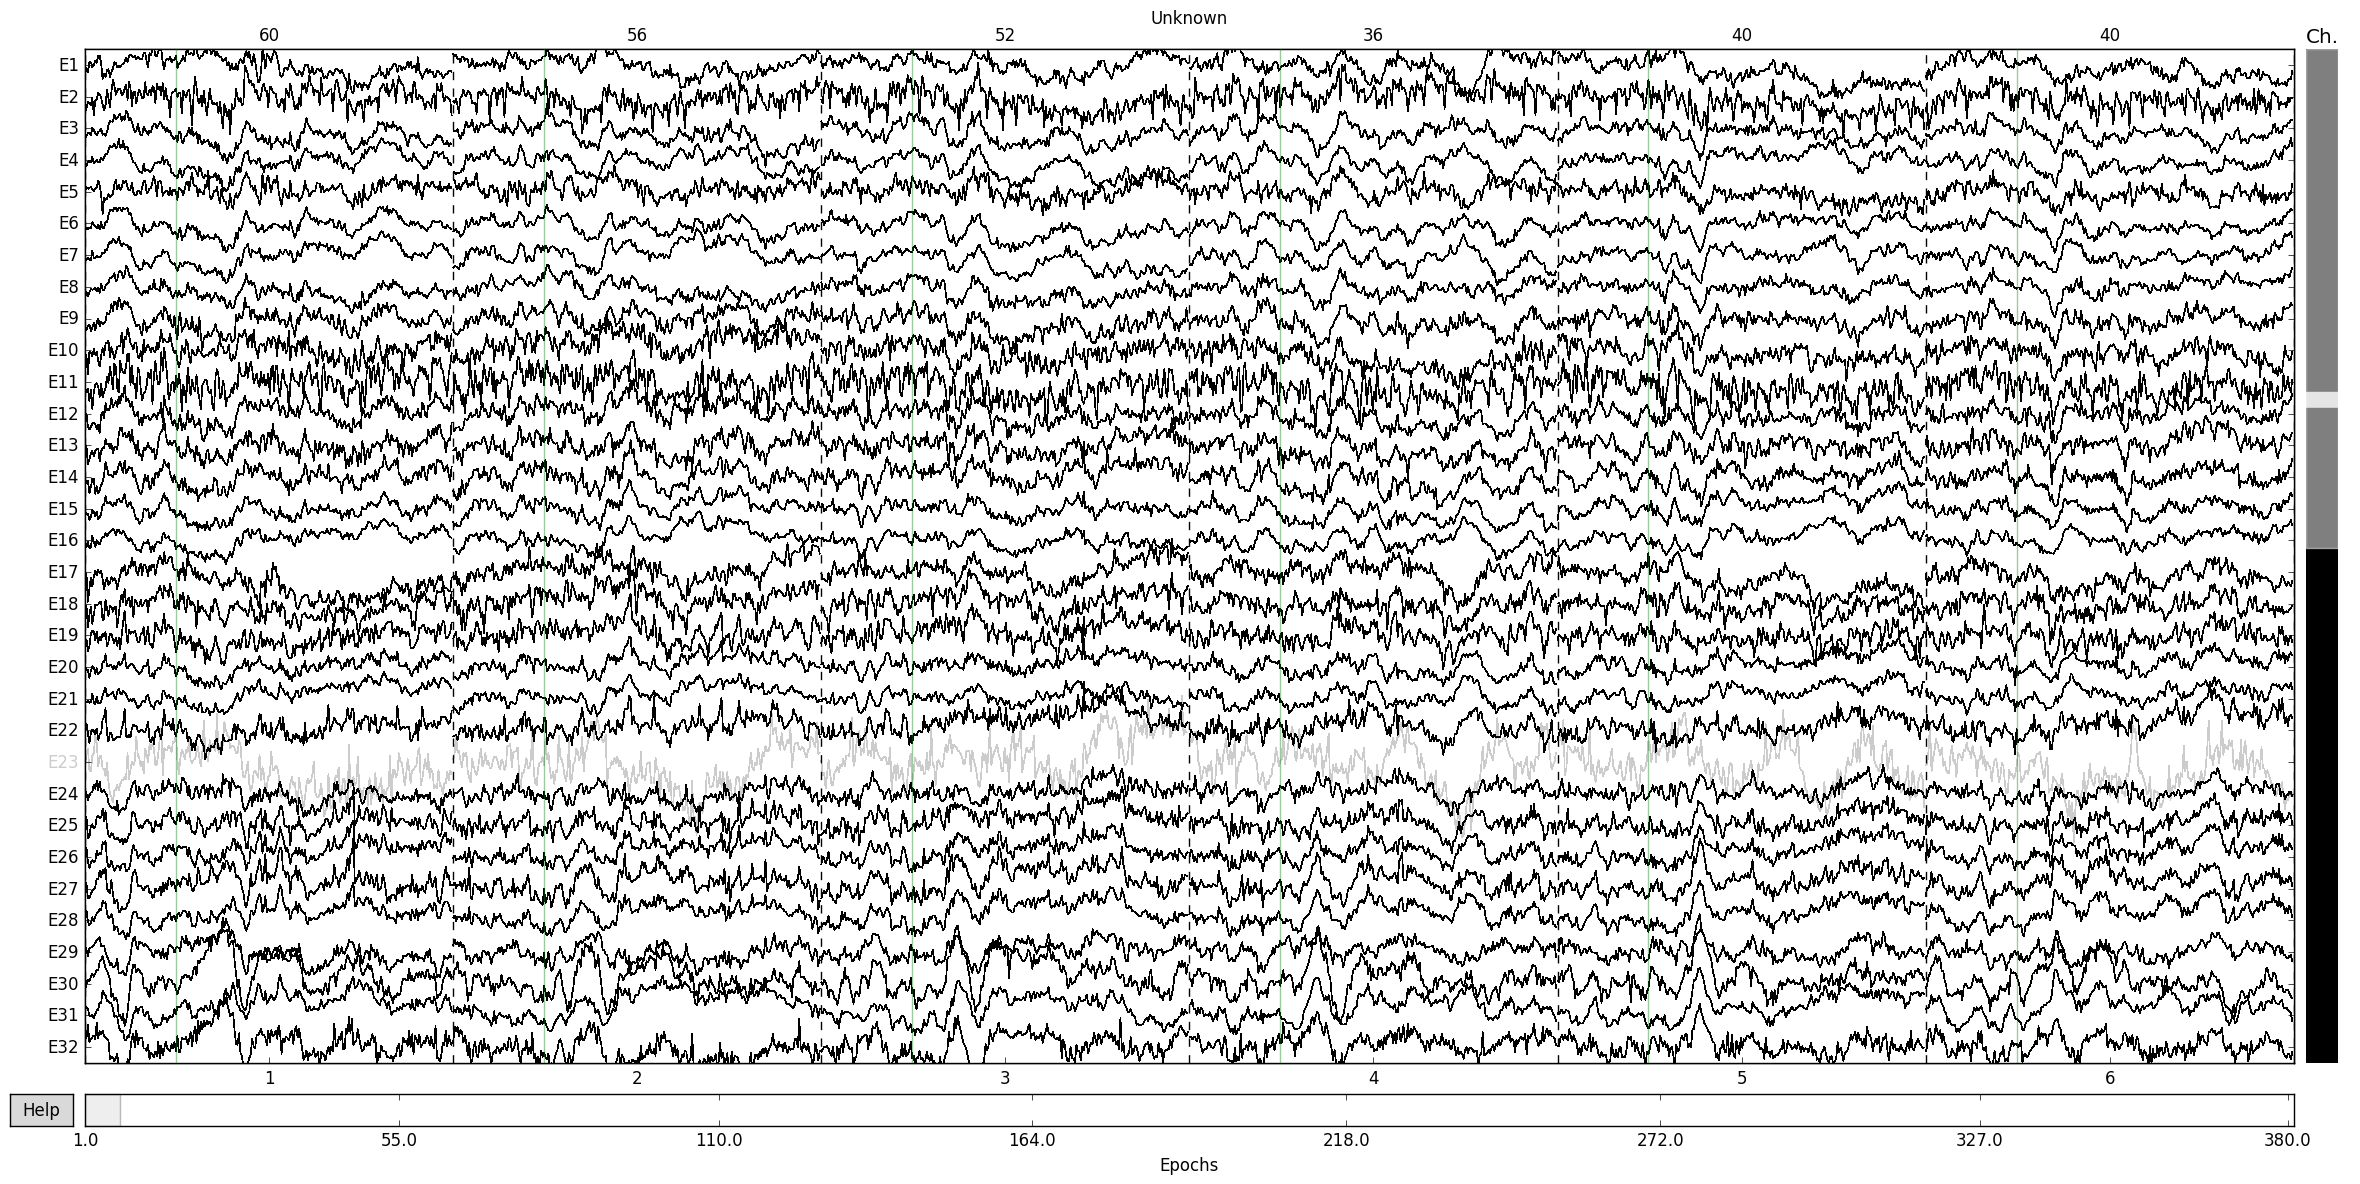

Dropped 0 epochs
Channels marked as bad: ['E23']


In [28]:
epochs_clean.plot(n_epochs=6, n_channels=32)

In [29]:
erp_face = epochs_clean.average()

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


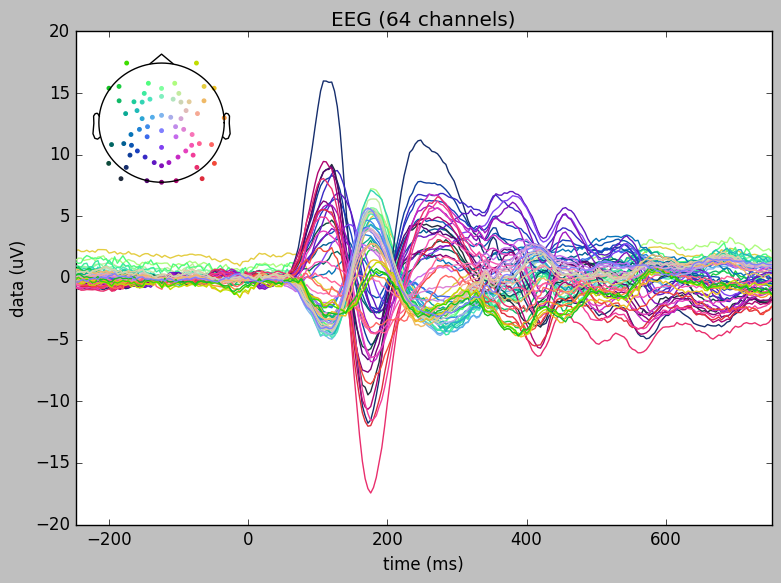

In [30]:
erp_face.plot(spatial_colors=True)